# Water classification and quantification


### Introduction


This notebook is a submission for technical assessment at GalaxEye Space.

The main objective of the notebook is to classify whether the provided AOIs contain water using satellite optical imagery, and if they do, to quantify the area occupied by water. In the end, a CSV file is to be generated summarizing this analysis.


Before we begin the analysis, let us look at the need for this type of analysis and the methodologies that can be employed using satellite optical imagery.


### Context


The areas of interest (AOI) provided for this task are [fishing ponds](https://www.fao.org/fishery/static/FAO_Training/FAO_Training/General/x6708e/x6708e01.htm) located in Andhra Pradesh, India. These ponds are fed with freshwater from rivers and nearby canals for farming aquatic organisms such as fish, crustaceans, mollusks, and aquatic plants. For this application, understanding the presence of water and analyzing water quality is crucial. And it becomes increasingly difficult to do so in person because the areas to be managed are quite large. This is where remotely sensed data and imagery can become invaluable, due to their ability to monitor and analyze large areas efficiently and cost-effectively. Not only can it help in large-scale monitoring, but it can also assist in events of pollution spills and algal blooms with its near real-time data, provide a non-invasive way to collect data to not disturb the aquatic environment, and in general, help with prompt decision making.


### Data collection


A list of ponds to be monitored has been provided and can be found [here](https://gist.github.com/RohitP103/94cc2923da03cfa231e33d6879b25fef).


To perform this analysis, Sentinel-2 L2A imagery is being used as the source of optical satellite imagery. Sentinel-2 mission is managed by the European Union's Copernicus Program and aims to provide multi-spectral data to improve monitoring of Earth. The constellation consists of 2 satellites - Sentinel-2A & 2B (the 3rd satellite S-2C is planned for launch later this year) and together, they cover the entire earth with a revisit frequency of ~5 days. The sensors on the satellite capture 13 spectral bands ranging from visible to short wave infrared wavelengths, and provide imagery with a spatial resolution of 10m, 20m, and 60m. For our analysis, we will be using band B03 (Green - 560nm) and band B08 (NIR - 842nm). Sentinel-2 L2A also includes a Scene Classification Layer (SCL) at 20m resolution and provides a basic distinction between cloudy, clear, and water pixels. We will be using this band to mask any cloudy pixels in our areas of interest.


### Tools and Platforms


The data is obtained from its original source: the [Copernicus Dataspace Ecosystem](dataspace.copernicus.eu). The data is being obtained and processed with the Sentinel Hub APIs which are included in the suite of APIs offered by this platform. This choice was made because the Processing API allows us to download exactly the data we are interested in (just the AOIs and only the bands we are interested in), instead of wasting huge amounts of storage space by downloading entire tiles of satellite imagery.


Another tool being used is QGIS. This software is used purely to convert the CSV file, which was provided with the task, to GeoJSON for easier analysis.


### Methodology


To analyze whether there is the presence of water, remote sensing indices can be used to make a decision. Water absorbs light in the visible to infrared electromagnetic spectrum, so very little of it is reflected in these bands of the electromagnetic spectrum. The vegetation reflects most of the Near-Infrared part of the spectrum, and that is how it can be distinguished. The image below can give a better understanding of the spectral signatures of different types of surfaces within the part of the spectrum that Sentinel-2 sensors operate in.


![Spectral signaure](./images/Spectral_signature.png)


From the image above, we can see that our example area of interest has a spectral signature much closer to that of water as compared to other example surfaces (the increased reflectance might be due to the presence of some vegetation/algae in the water).


[Normalized Difference Water Index (NDWI)](https://custom-scripts.sentinel-hub.com/sentinel-2/ndwi/) is a remote sensing index that can help us understand whether water exists in a region or not. Typically, the NDWI can fall in the range of [-1,1], but it is considered that a pixel represents water if the reflectance relates to an NDWI in the range of [0.5,1.0]. Since our ponds are shallow and quite small, we will see a lower threshold used to make this decision (based on the distribution of NDWI). The NDWI is mathematically represented below.


$$

NDWI = \frac{Green - NIR}{Green + NIR}

$$


This index is used to identify the water pixels, create a binary mask (`waterMask`) over the AOIs, and then calculate the total area covered by water using the `waterMask` and the knowledge of the spatial resolution of each pixel.


Now, with this understanding, let us begin our analysis by importing all the necessary Python packages.

### Workflow
##### Imports

In [1]:
import getpass
from datetime import datetime
import json

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
import geopandas as gpd
from ipyleaflet import GeoJSON, Map, basemaps
from sentinelhub import (
    CRS,
    Geometry,
    DataCollection,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    SHConfig,
)

##### Configuration

To use the tools and services of the [Copernicus Dataspace Ecosystem](https://dataspace.copernicus.eu), we first need to have a registered account and create an OAuth Client in the [User Settings](https://shapps.dataspace.copernicus.eu/dashboard/#/account/settings) of the [Sentinel Hub Dashboard](https://shapps.dataspace.copernicus.eu/dashboard/#/). Once we have our `Client ID` and `Client Secret`, we can run the box below, and input the information as prompted. This saves the credentials locally with the profile name we prode when saving so it can be called whenever we need again. If this has already been done previously, we can ignore the cell below and just uncomment and run the next cell with the proper profile name.

In [2]:
config = SHConfig()
config.sh_client_id = getpass.getpass("Enter your SentinelHub client id")
config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret")
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
config.save("cdse")

In [3]:
# config = SHConfig("cdse")

##### Setting up area of interest

The CSV file provided with the task has been converted to GeoJSON with QGIS. Then, the GeoJSON file is being read as a GeoPandas dataframe in the below cell. The Coordinate reference system of the polygons are being transformed from WGS84 (EPSG:4326) to EPSG:32644 (UTM 44N) to have all our units in meters. This is because the API we will use later in the analysis considers the unit of resolution from the CRS of the polygons being used.

The polygons are then displayed over a map to understand the locations of all the fishing ponds.

In [4]:
SHAPE_PATH = "./data/AssignmentPonds.geojson"
ponds_gdf = gpd.read_file(SHAPE_PATH)

# Convert to EPSG 7755
ponds_gdf = ponds_gdf.to_crs("EPSG:32644")
# Geometry of an entire area
resolution = (10, 10)

data = json.load(open(SHAPE_PATH, "r"))

# Set center and zoom level
center = [15.25, 80.5]
zoom = 8

# Add OSM background
m = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=center, zoom=zoom)

# Add geojson data
geo_json = GeoJSON(data=data)
m.add_layer(geo_json)

# Display
m

Map(center=[15.25, 80.5], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

##### Setting up time range

For this analysis, there was no particular date mentioned. So the time interval was chosen to be in the beginning of summer to capture ponds with differnet levels of water and also to avoid loss of data due to clouds.

In [5]:
start = datetime(2024, 4, 20)
end = datetime(2024, 4, 30)

time_interval = (start, end)

##### Processing

To create a custom visualization with the Sentinel Hub's [Processing API](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Process.html), we need a piece of JavaScript code called the `evalscript` (short for Evaluation Script). This script defines the input and output in its `setup` function and the processing chain in the `evaluatePixel` function. There is an additional `isValid` function defined to filter out the cloudy pixels. 

Looking into the `evaluatePixel()` we can see that an normalised difference index is calculated with the Bands B03 and B08 and a very generous threshold of 0.15 is set to create a binary `waterMask` that represents whether a pixel shows water or not. The threshold is considered to be generous because the AOIs we are looking at are quite small and the ponds are shallow. So regions where the pixel only partially covers the ponds might have lower average NDWI over the 10m * 10 m area and might get neglected if we set a higher threshold. This number was also decided after looking at the pixel count distribition of NDWI for each of the ponds.

The output of this request will give us 3 bands:
* The NDWI vlues over the AOI,
* The binary `waterMask`
* An additional mask to represent whether data is available or not - `dataMask`

In [6]:
evalscript_ndwi = """
//VERSION=3

function setup() {
  return {
    input: ["B03","B08", "SCL", "dataMask"],
    output: { bands: 3, sampleType: "FLOAT32"}
  };
}

function isValid(samples){
  var scl = samples.SCL;

  if (scl === 3) { // SC_CLOUD_SHADOW
    return false;
  } else if (scl === 9) { // SC_CLOUD_HIGH_PROBA
    return false;
  } else if (scl === 8) { // SC_CLOUD_MEDIUM_PROBA
    return false;
  } else if (scl === 7) { // SC_CLOUD_LOW_PROBA / UNCLASSIFIED
    // return false;
  } else if (scl === 10) { // SC_THIN_CIRRUS
    return false;
  } else if (scl === 11) { // SC_SNOW_ICE
    return false;
  } else if (scl === 1) { // SC_SATURATED_DEFECTIVE
    return false;
  } else if (scl === 2) { // SC_DARK_FEATURE_SHADOW
    // return false;
  }
  return true;
}

function evaluatePixel(samples) {
  let index = (samples.B03-samples.B08)/(samples.B03+samples.B08);
  let waterMask = 0
  if (isValid(samples) & index > 0.15) {
    waterMask = 1;
  }

  return [index,waterMask,samples.dataMask];
}
"""

Here, we define a function that creates a request for the API by taking in the `evalscript`, `geometry`, `crs` and the `time_interval`. The request is being made for Sentinel-2 L2A imagery and the image being selected is the least cloudy image over the time interval. The expected output is set to be of the `TIFF` format, and the results are to be saved in the `results` folder in the local directory. Running this cell will not send the request, but just create it.

In [7]:
def ndwi_request(evalscript, geometry, crs, time_interval):
    return SentinelHubRequest(
        evalscript=evalscript_ndwi,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A.define_from(
                    "s2l2a", service_url=config.sh_base_url
                ),
                time_interval=time_interval,
                mosaicking_order=MosaickingOrder.LEAST_CC,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        geometry=Geometry(geometry, crs=crs),
        resolution=resolution,
        config=config,
        data_folder="./results",
    )

In this cell, we are creating a request for each of the ponds in the list of AOIs. Running this cell will still not send the request but only prepare the list of requests.

In [8]:
list_requests = [
    ndwi_request(evalscript_ndwi, pond, ponds_gdf.crs, time_interval)
    for pond in ponds_gdf.geometry.values
]
list_requests = [request.download_list[0] for request in list_requests]

Finally, when we are ready with all the requests, we can use the `SentinelHubDownloadClient` to parallely download the requested data. Since our AOIs are small and the data requested are just a few bands, the processing will not take too long. The results will be stored in a local folder called `results`.

In [9]:
# download data with multiple threads
ponds_classification = SentinelHubDownloadClient(config=config).download(
    list_requests, max_threads=5
)

##### Visualization

When we run the next cell, we can see the NDVI values for all the ponds. The colourbar below the image shows the range for which these images gave been plotted.

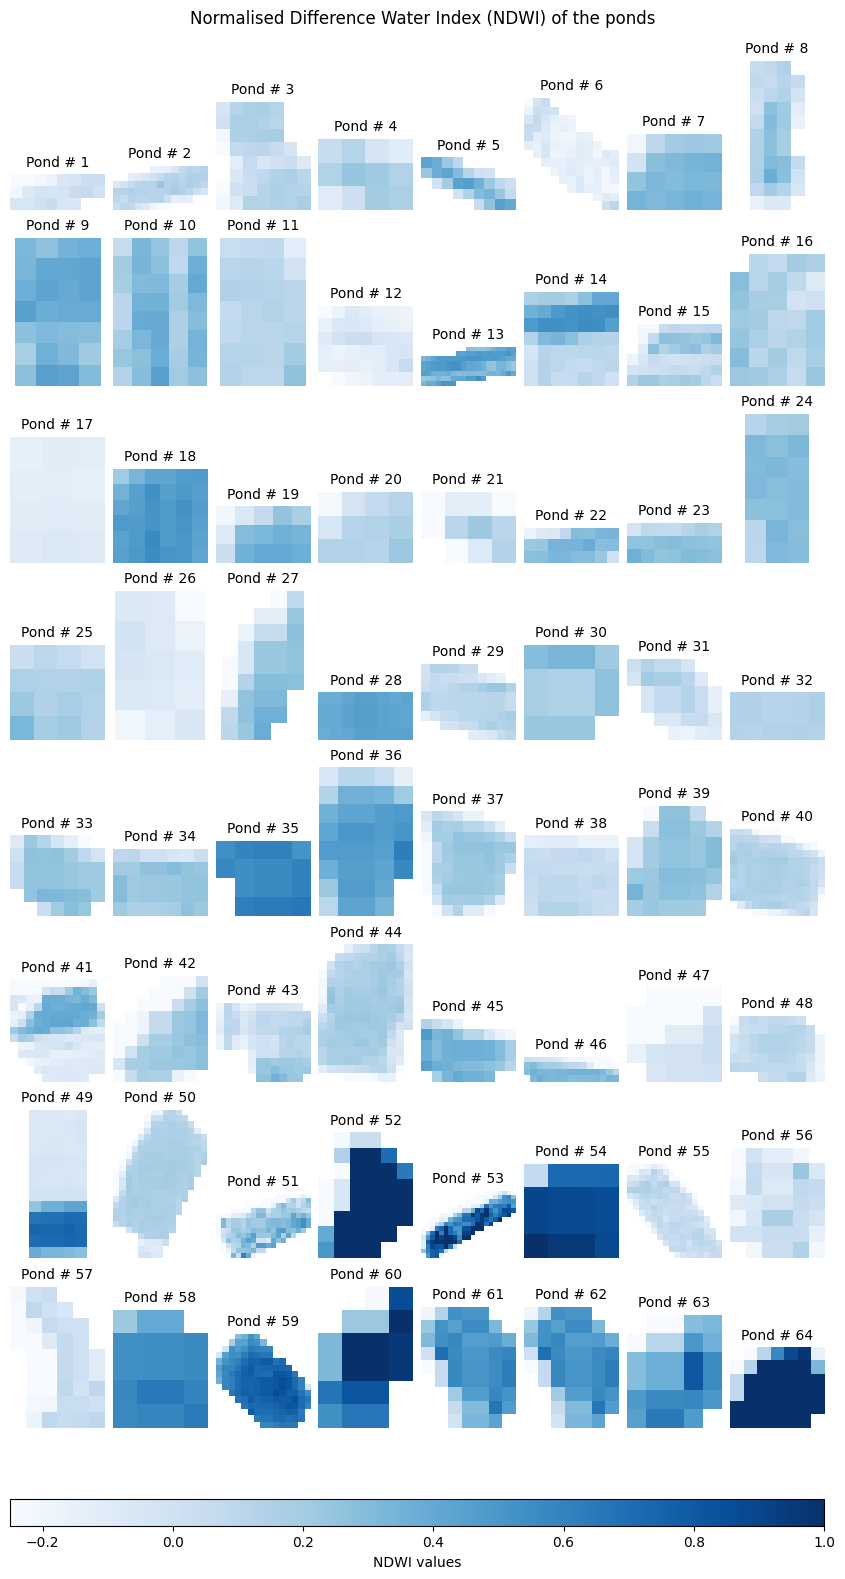

In [10]:
ncols = 8
nrows = 8
aspect_ratio = 2
subplot_kw = {"xticks": [], "yticks": [], "frame_on": False}

fig, axs = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    figsize=(2 * ncols * aspect_ratio, 2 * nrows),
    subplot_kw=subplot_kw,
    layout="compressed",
)
fig.suptitle("Normalised Difference Water Index (NDWI) of the ponds")
image_list = []
for idx, image in enumerate(ponds_classification):
    ax = axs[idx // ncols][idx % ncols]
    im = ax.imshow(image[:, :, 0], cmap=plt.cm.Blues, vmin=-0.25, vmax=1)
    image_list.append(im)
    ax.set_title(f"Pond # {ponds_gdf.Pond[idx]}", fontsize=10)

cbar = fig.colorbar(im, ax=axs, orientation="horizontal", fraction=0.05, aspect=30)
cbar.set_label("NDWI values")

plt.show()

We can determine the threshold by looking at the distribution of pixel values representing NDWI of the ponds. After considering factors such as size of the pond and assuming shallow depth, the threshold for the binary mask was selected to be 0.15.

(-1.0, 1.0)

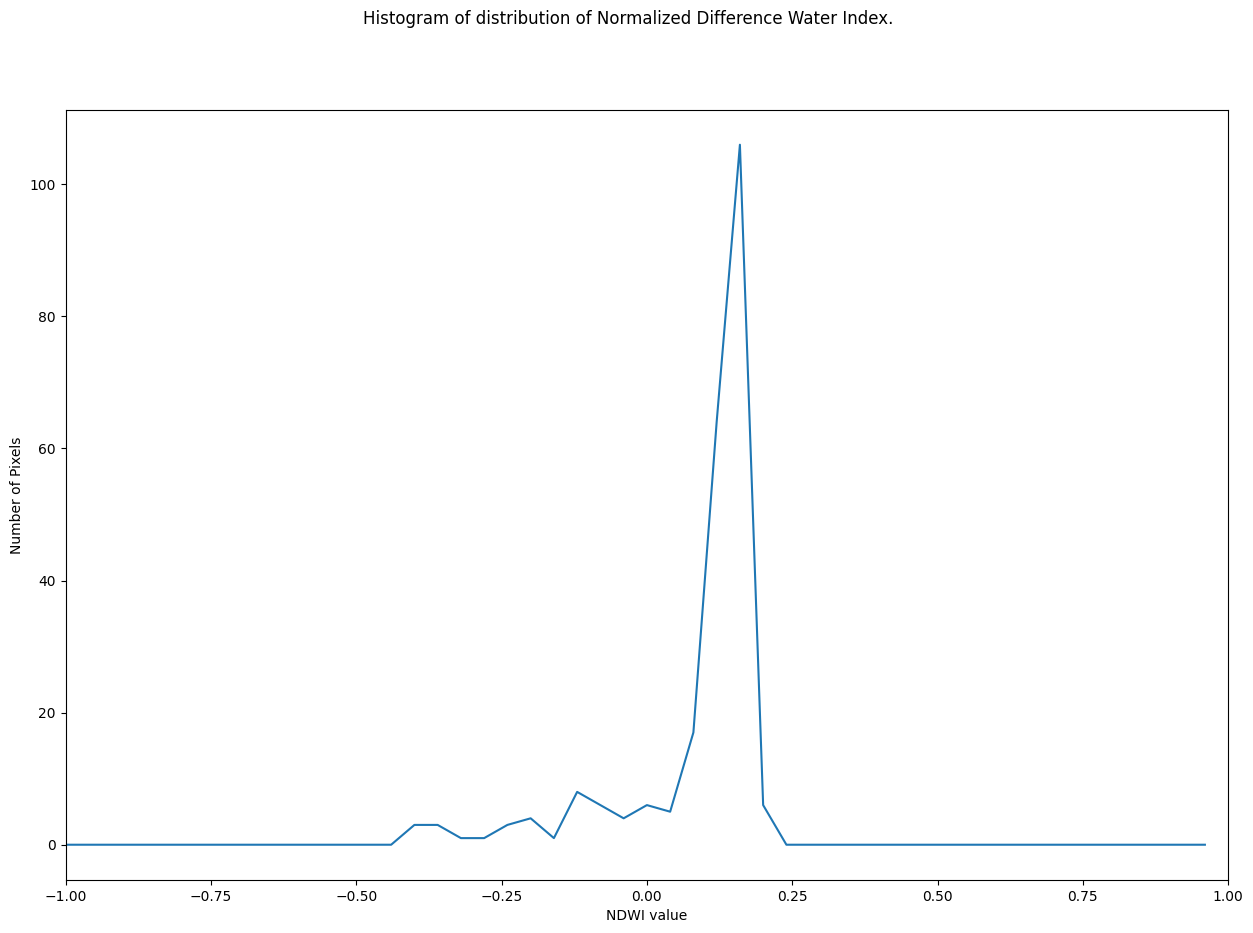

In [11]:
histogram, bin_edges = np.histogram(
    ponds_classification[49][:, :, 0], bins=50, range=(-1, 1)
)

f, ax = plt.subplots()
f.set_figwidth(15)
f.set_figheight(10)
f.suptitle("Histogram of distribution of Normalized Difference Water Index.")

# Histogram
plt.plot(bin_edges[0:-1], histogram)
plt.xlabel("NDWI value")
plt.ylabel("Number of Pixels")
plt.xlim(-1, 1)
# plt.savefig('NDMI_diff_hist.png', transparent=True)

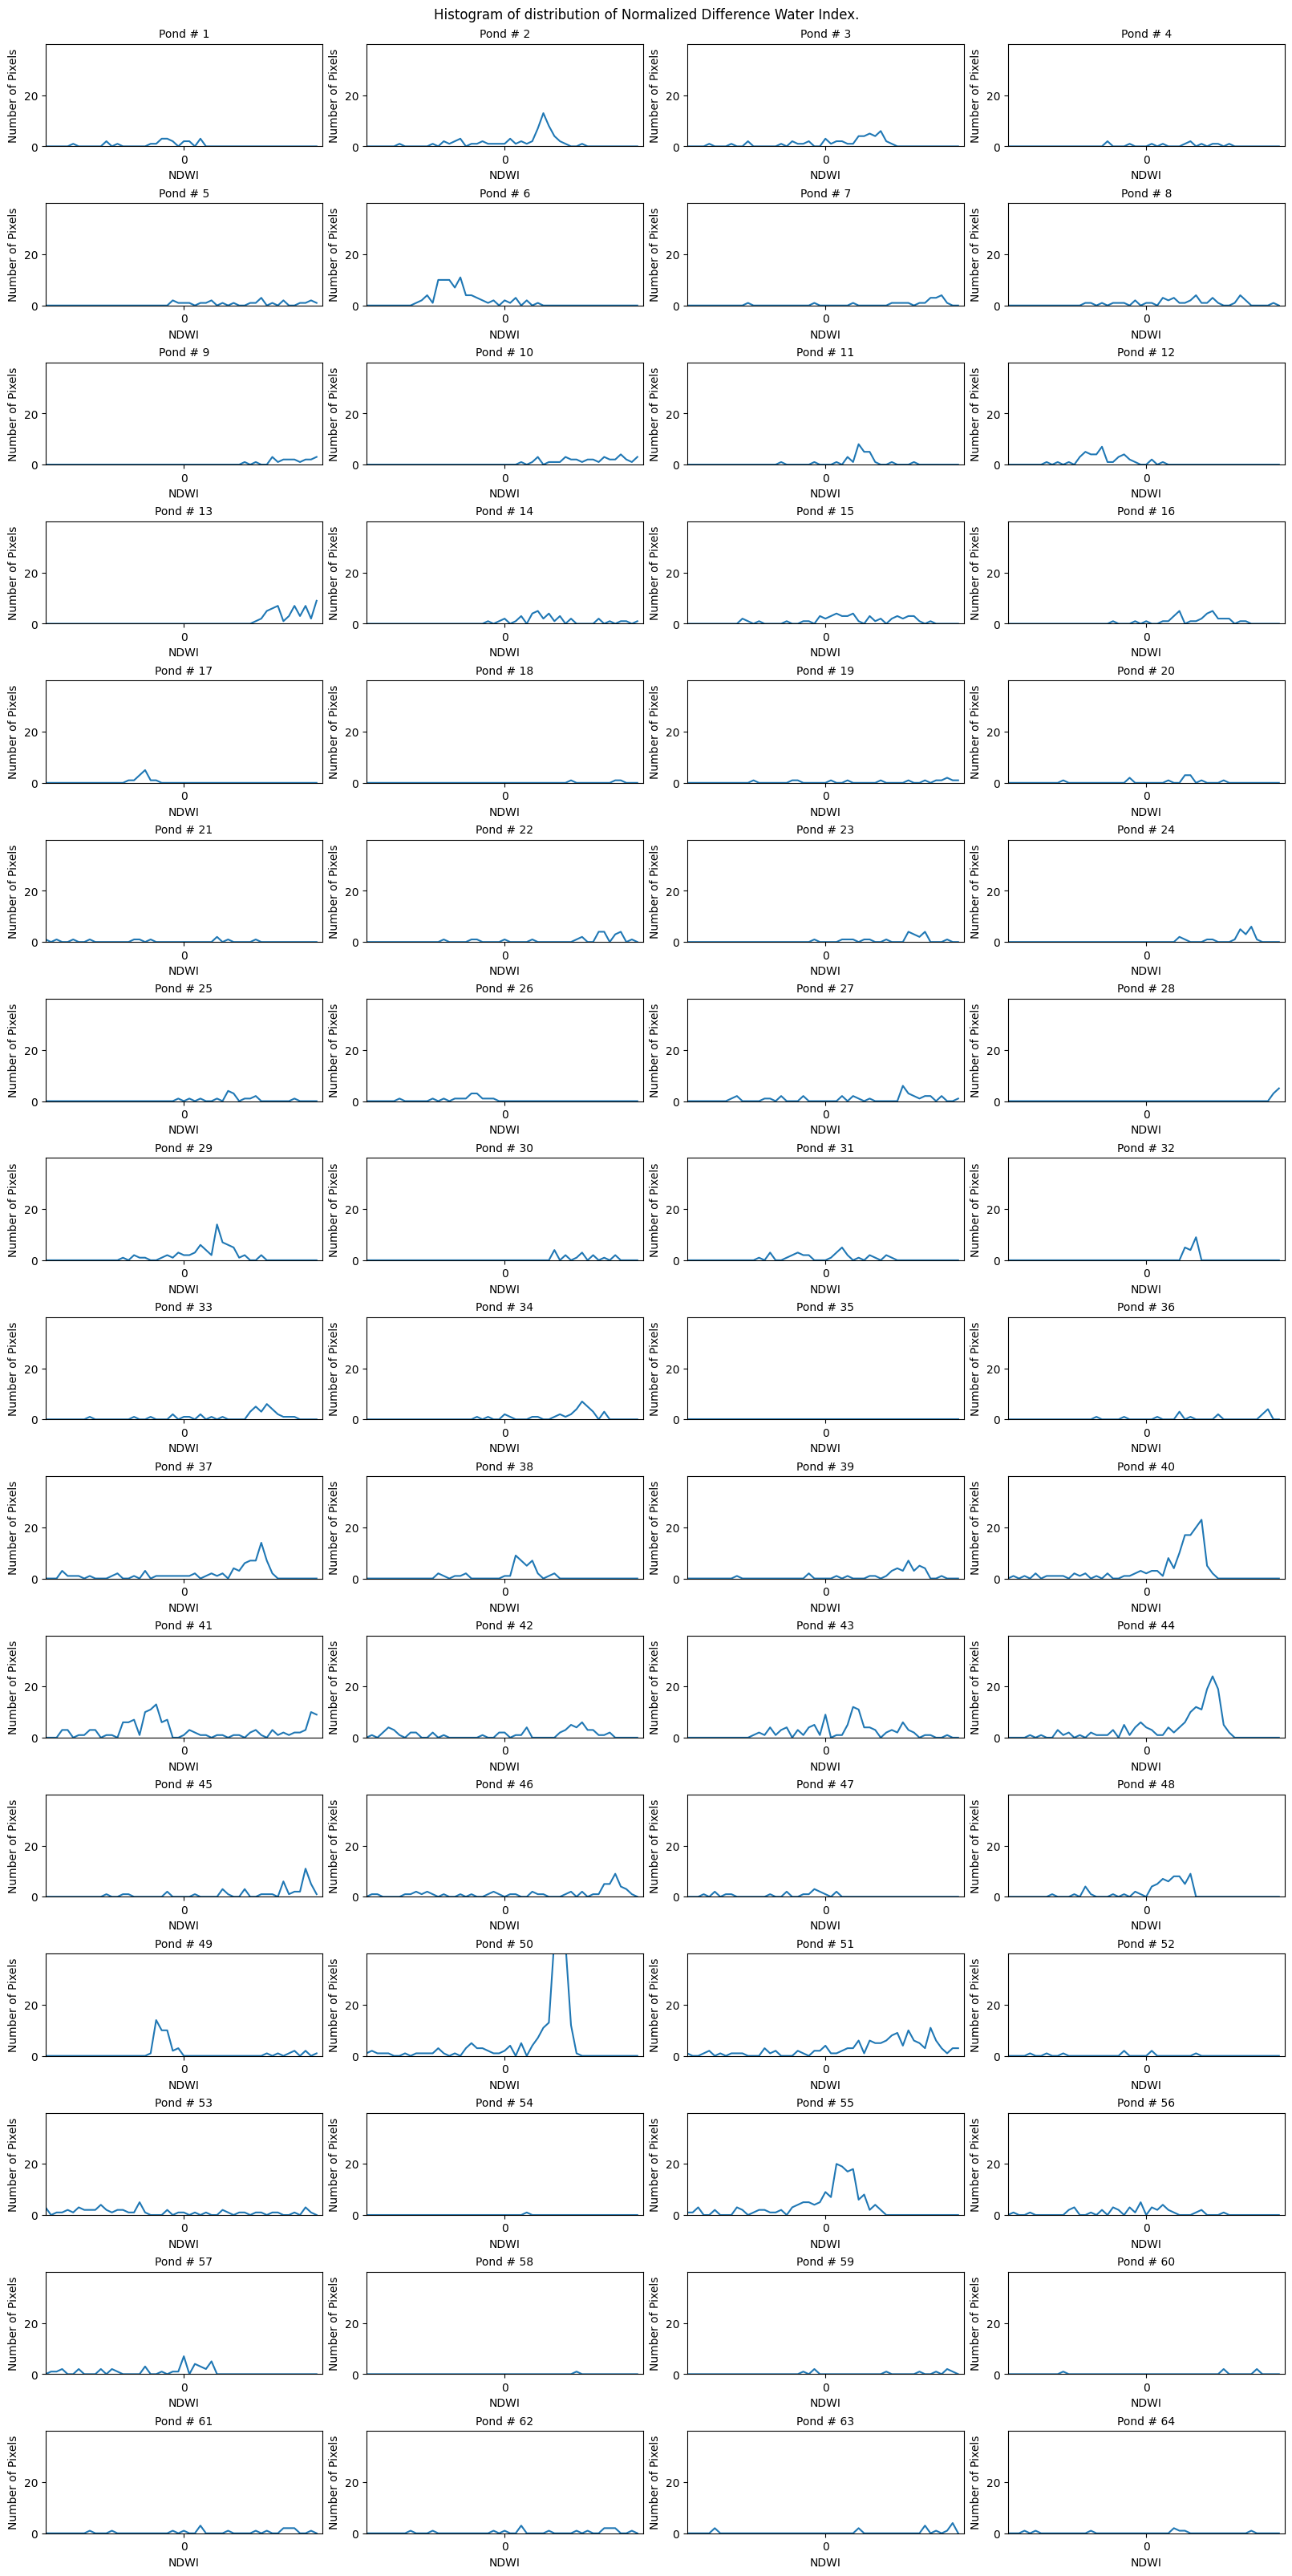

In [12]:
ncols = 4
nrows = 16
aspect_ratio = 2
subplot_kw = {"xticks": range(0, 1), "yticks": range(0, 40, 20), "frame_on": True}

fig, axs = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    figsize=(2 * ncols * aspect_ratio, 2 * nrows),
    subplot_kw=subplot_kw,
    layout="compressed",
)
fig.suptitle("Histogram of distribution of Normalized Difference Water Index.")

for idx, image in enumerate(ponds_classification):
    histogram, bin_edges = np.histogram(2.5 * image[:, :, 0], bins=50, range=(-1, 1))
    ax = axs[idx // ncols][idx % ncols]
    ax.plot(bin_edges[0:-1], histogram)
    ax.set_xlabel("NDWI")
    ax.set_ylabel("Number of Pixels")
    ax.set_xlim((-1, 1))
    ax.set_ylim((0, 40))
    ax.set_title(f"Pond # {ponds_gdf.Pond[idx]}", fontsize=10)

plt.show()

We can also take a look at the binary water mask that represents whether a pixel contains image of water or not. 

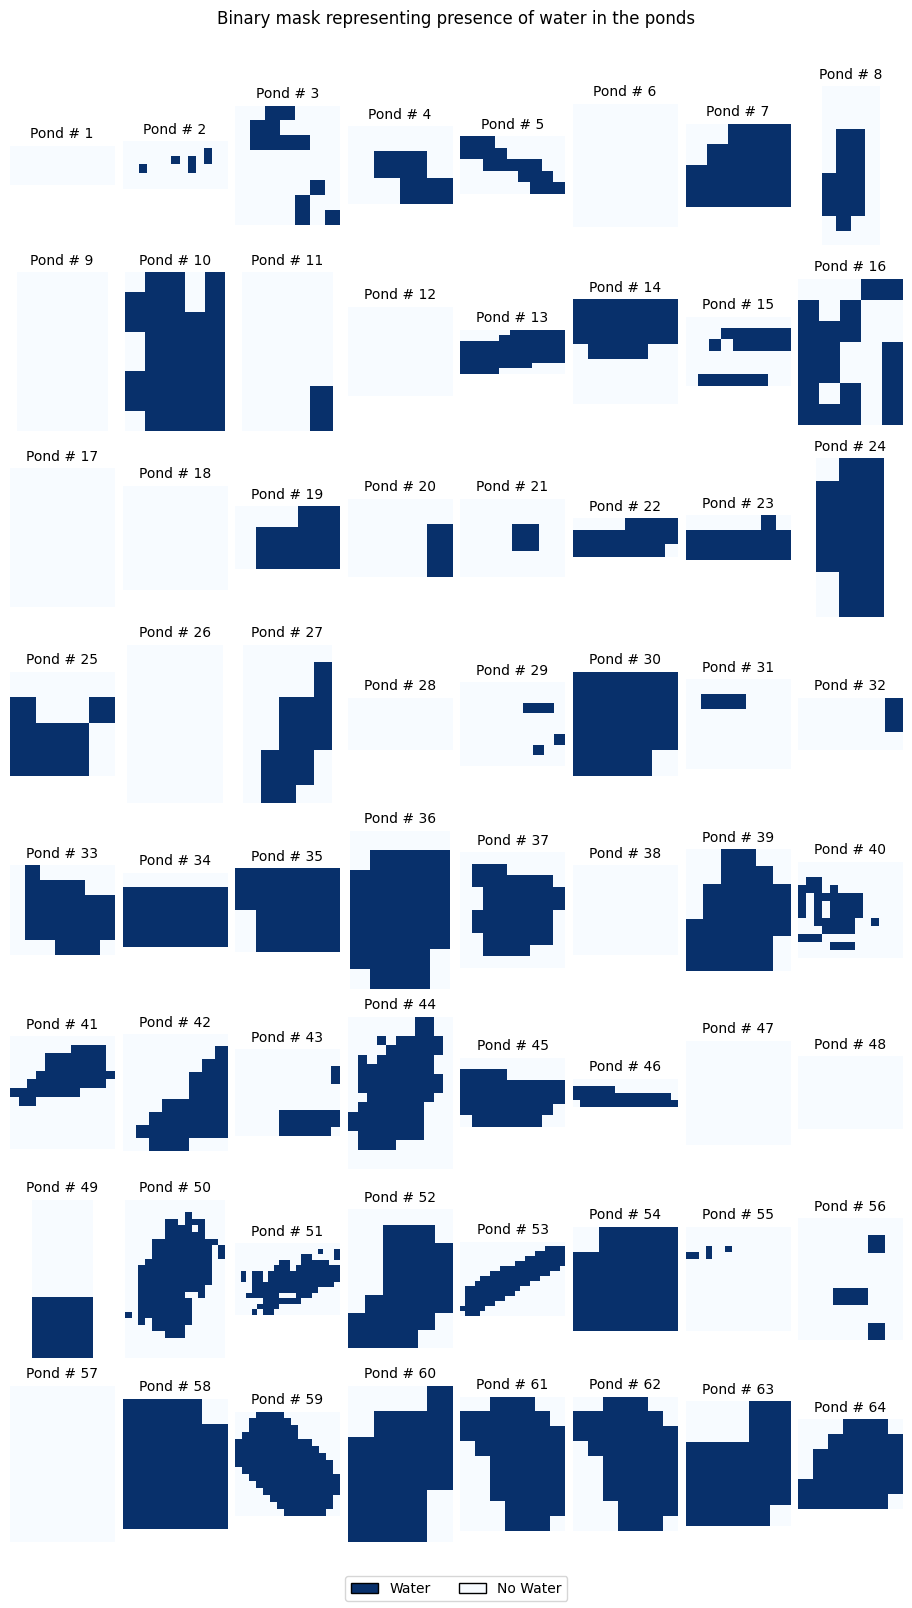

In [13]:
ncols = 8
nrows = 8
aspect_ratio = 2
subplot_kw = {"xticks": [], "yticks": [], "frame_on": False}

legend_elements = [
    Patch(facecolor="#08306B", edgecolor="k", label="Water"),
    Patch(facecolor="#F7FBFF", edgecolor="k", label="No Water"),
]

fig, axs = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    figsize=(2 * ncols * aspect_ratio, 2 * nrows),
    subplot_kw=subplot_kw,
    layout="compressed",
)
fig.suptitle("Binary mask representing presence of water in the ponds")

for idx, image in enumerate(ponds_classification):
    ax = axs[idx // ncols][idx % ncols]
    im = ax.imshow(image[:, :, 1], cmap=plt.cm.Blues)
    ax.set_title(f"Pond # {ponds_gdf.Pond[idx]}", fontsize=10)

fig.legend(handles=legend_elements, loc="lower center", ncols=2)

plt.show()

##### Quantification

Now it is time to quantify our results. Since we have obtained a binary mask over that ponds, adding them all together will give us a count of water pixels in a pond. Then, multiplying this with the spatial resolution of each pixel will give us the area covered by water in each pond. 

So in the next cell, a function that calculates the count of total number of pixels representing water is defined. And the cell after that creates 2 arrays: one describing the area covered by water and the other giving us a status of precence of water in the pond.

In [14]:
def count_water_pixels(image):
    water_mask = image[:, :, 1]

    # Count the number of blue pixels
    water_pixel_count = np.sum(water_mask)

    # print(water_pixel_count)
    return water_pixel_count

In [15]:
resolution_s2 = 10 * 10  # meters
area_covered_water = []
water_status = []
for image in ponds_classification:
    water_pixels_count = count_water_pixels(image)
    area_covered_water.append(water_pixels_count * resolution_s2)
    water_status.append(1 if water_pixels_count > 0 else 0)

We can add this new information to the original dataframe we and export it as a CSV file.

In [16]:
ponds_gdf["Area(sqm)"] = area_covered_water
ponds_gdf["Water_status"] = water_status
ponds_gdf

,Pond,Link,centriod,geometry,Area(sqm),Water_status
0,1,https://www.google.com/maps?q=15.9097716016521...,"(15.909771601652196, 80.5101859752401)","POLYGON ((447611.966 1759017.196, 447611.966 1...",0.0,0
1,2,https://www.google.com/maps?q=15.9073785273048...,"(15.907378527304822, 80.51165072296921)","POLYGON ((447658.034 1758728.035, 447658.034 1...",600.0,1
2,3,https://www.google.com/maps?q=15.9080633321265...,"(15.908063332126533, 80.5111462520874)","POLYGON ((447651.652 1758825.091, 447651.579 1...",1200.0,1
3,4,https://www.google.com/maps?q=15.9052441404584...,"(15.905244140458427, 80.6585489495667)","POLYGON ((463428.035 1758501.122, 463438.338 1...",400.0,1
4,5,https://www.google.com/maps?q=15.9003483917881...,"(15.900348391788192, 80.64620910177594)","POLYGON ((462114.272 1757961.965, 462114.405 1...",1800.0,1
...,...,...,...,...,...,...
59,60,https://www.google.com/maps?q=16.1881587718507...,"(16.188158771850727, 81.11642739689296)","POLYGON ((512445.034 1789774.98, 512464.966 17...",1800.0,1
60,61,https://www.google.com/maps?q=16.1920629513337...,"(16.1920629513337, 81.12248814387651)","POLYGON ((513065.031 1790224.965, 513094.981 1...",4400.0,1
61,62,https://www.google.com/maps?q=16.1920629513337...,"(16.1920629513337, 81.12248814387651)","POLYGON ((513065.031 1790224.965, 513094.981 1...",4400.0,1
62,63,https://www.google.com/maps?q=16.1927015132574...,"(16.192701513257482, 81.12152041321168)","POLYGON ((513014.965 1790274.981, 513014.965 1...",2300.0,1


In [17]:
ponds_df = pd.DataFrame(ponds_gdf)
ponds_df.to_csv("AssignmentPonds_out.csv", index=False)

### Summary

With this task, the given areas of interest have been analysed to detect presence of water and quantify the are it covers with the help of optical satellite imagery. 

This workflow can be improved by creating a fusion of Sentinel-1 (SAR) data with Sentinel-2 (multi-spectral) in order to avoid the effects of clouds during the monsoon season. Using higher resolution (VHR) datasets could also help with more precise results. 